In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import mutual_info_regression

## EDA

Dataset source: https://www.kaggle.com/datasets/andreylss/residential-and-commercial-energy-cost-dataset

In [27]:
df = pd.read_csv('energy_consumption.csv')

In [28]:
df.head()

,customer_id,customer_type,regions,building_size_m2,occupants,energy_cost_brl
0,CUSTOMER_0001,residential,Northeast,24,2,64.51
1,CUSTOMER_0002,commercial,Midwest,24,1,55.26
2,CUSTOMER_0003,commercial,Southeast,24,1,74.54
3,CUSTOMER_0004,residential,Northeast,45,4,147.06
4,CUSTOMER_0005,residential,Southeast,45,4,143.06


In [29]:
# check data types
df.dtypes

customer_id          object
customer_type        object
regions              object
building_size_m2      int64
occupants             int64
energy_cost_brl     float64
dtype: object

In [30]:
# check for missing values
df.isnull().sum()

customer_id         0
customer_type       0
regions             0
building_size_m2    0
occupants           0
energy_cost_brl     0
dtype: int64

In [31]:
# get summary statistics
df.describe()

,building_size_m2,occupants,energy_cost_brl
count,5000.00000,5000.000000,5000.000000
mean,39.57620,2.301800,86.874028
std,17.51638,1.032729,24.383261
min,17.00000,1.000000,52.520000
25%,24.00000,1.000000,68.557500
50%,45.00000,2.000000,83.715000
75%,45.00000,3.000000,98.242500
max,77.00000,4.000000,158.610000


In [32]:
# check for duplicate rows
df.duplicated().sum()

np.int64(0)

In [33]:
# How energy cost varies by region
region_consumption = df.groupby('regions')['energy_cost_brl'].mean().reset_index()
region_consumption

,regions,energy_cost_brl
0,Midwest,86.307266
1,North,87.594638
2,Northeast,86.927401
3,South,86.743942
4,Southeast,88.097547


In [37]:
## How energy cost differs between residential and commercial buildings
building_type_consumption = df.groupby('customer_type')['energy_cost_brl'].mean().reset_index()
building_type_consumption

,customer_type,energy_cost_brl
0,commercial,86.353076
1,residential,87.151837


Text(0.5, 1.0, 'Average Energy Cost by Square Footage')

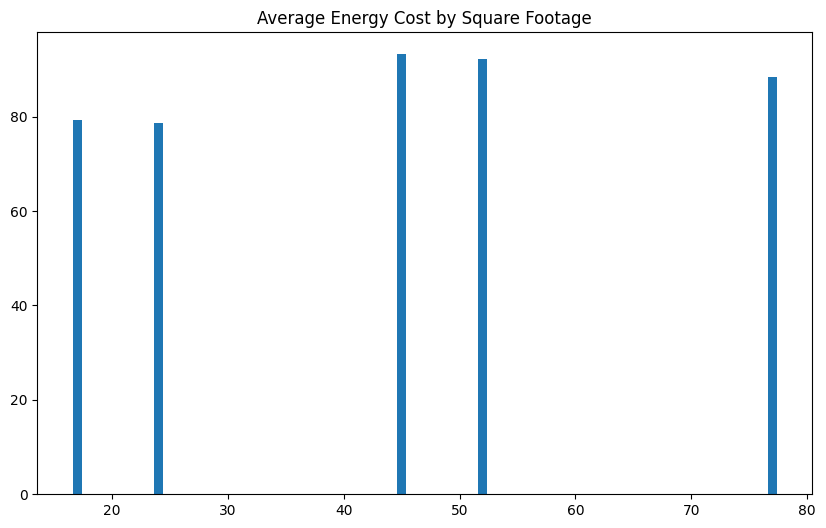

In [43]:
# Barplot for average energy cost by square footage, as we have discrete values
plt.figure(figsize=(10,6))
sqm_consumption = df.groupby('building_size_m2')['energy_cost_brl'].mean().reset_index()
plt.bar(sqm_consumption['building_size_m2'], sqm_consumption['energy_cost_brl'])
plt.title('Average Energy Cost by Square Footage')

In [44]:
sqm_consumption

,building_size_m2,energy_cost_brl
0,17,79.272823
1,24,78.612058
2,45,93.189150
3,52,92.131149
4,77,88.350648


Weirdly enough, the relationship between building size and energy cost is not linear. This could be due to various factors such as energy efficiency measures in larger buildings or different usage patterns.

Let's see the distribution of square footage between residential and commercial buildings. Maybe commercial buildings tend to be larger and have different energy consumption patterns.

In [62]:
# for each unique building size, count how many residential and commercial buildings there are
building_size_distribution = df.groupby(['building_size_m2', 'customer_type']).size()

In [64]:
type(building_size_distribution)

pandas.core.series.Series

In [65]:
building_size_distribution

building_size_m2  customer_type
17                commercial        246
                  residential       498
24                commercial        449
                  residential       800
45                commercial        696
                  residential      1280
52                commercial        181
                  residential       341
77                commercial        167
                  residential       342
dtype: int64

In [66]:
building_size_distribution.unstack()

customer_type,commercial,residential
building_size_m2,,
17,246,498
24,449,800
45,696,1280
52,181,341
77,167,342


In [91]:
total_per_size = building_size_distribution.sum(axis=0)
total_per_size

building_size_m2
17     744
24    1249
45    1976
52     522
77     509
dtype: int64

In [96]:
building_size_distribution = building_size_distribution.div(total_per_size, axis=1)
building_size_distribution = (building_size_distribution * 100).round(2)

In [97]:
building_size_distribution

building_size_m2,17,24,45,52,77
customer_type,,,,,
commercial,33.06,35.95,35.22,34.67,32.81
residential,66.94,64.05,64.78,65.33,67.19


No major difference

Text(0.5, 1.0, 'Average Energy Cost by Number of Occupants')

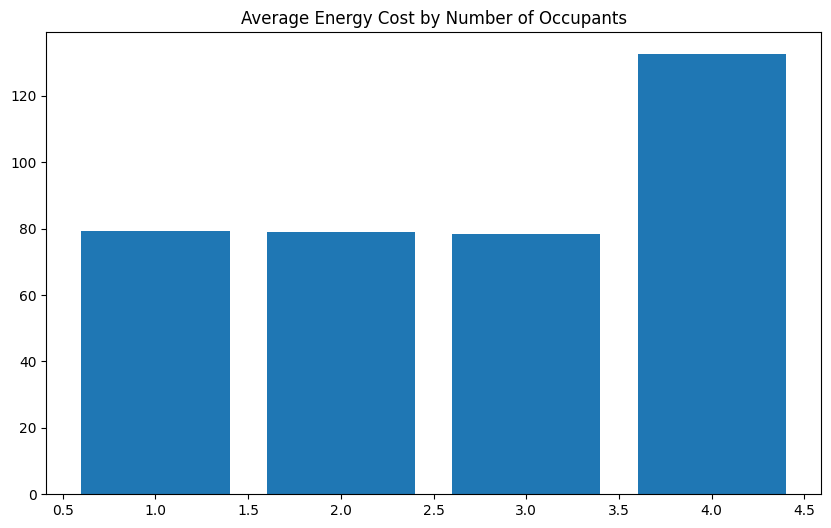

In [99]:
# distribution of energy cost per occupant
plt.figure(figsize=(10,6))
occupant_consumption = df.groupby('occupants')['energy_cost_brl'].mean().reset_index()
plt.bar(occupant_consumption['occupants'], occupant_consumption['energy_cost_brl'])
plt.title('Average Energy Cost by Number of Occupants')

In [100]:
occupant_consumption

,occupants,energy_cost_brl
0,1,79.147814
1,2,78.914681
2,3,78.314694
3,4,132.443227


In [101]:
# how many buildings have each number of occupants
occupant_distribution = df['occupants'].value_counts().sort_index()
occupant_distribution

occupants
1    1386
2    1472
3    1389
4     753
Name: count, dtype: int64

Again, two weird things:
1. From 1 to 3 occupants, the energy costs are unchanged. They even slightly decrease.
2. For 4 occupants, they almost double.

### Explanation

This dataset has been synthetically generated, and the distribution for energy consumption follows the given rules (which are unrealistic):

```
# Iterate through residents of each customer
for res in num_residents:
    if 1 <= res <= 3:
        energy_cost_brl.append(np.random.uniform(52.5, 103.85))
    else:
        energy_cost_brl.append(np.random.uniform(103.86, 158.67))
energy_cost_brl = [round(x, 2) for x in energy_cost_brl]
```

<Axes: >

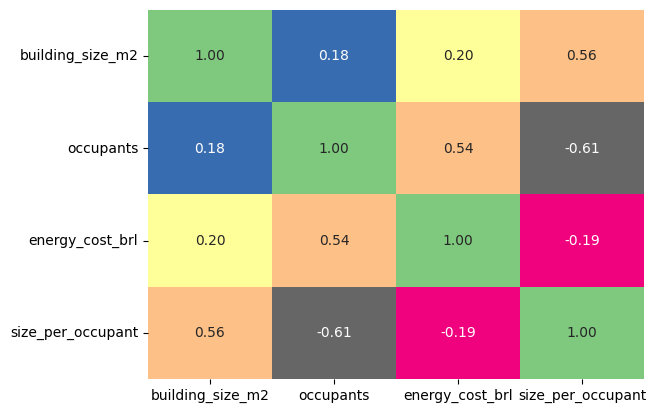

In [115]:
# Heatmap of correlations
corr = df.corr(numeric_only=True)
sns.heatmap(corr,
            annot=True, fmt='.2f',cmap="Accent_r",
            cbar=False)

Low correlations across the board, as expected from synthetic data. The 0.54 between energy cost and occupants is highly impacted by the distribution when occupants = 4.

## Feature Engineering

The core challenge is that the dataset is synthetically generated with predefined, non-linear, step-wise relationships, which results in low linear correlation (like Pearson's $r$) with the target variable (energy_cost_brl).The key to feature engineering here is to reverse-engineer the explicit rules used during data generation and use them to create new, highly predictive features. We should focus on binning and interaction terms.



The energy cost logic is:
- If $1 \le \text{occupants} \le 3$: Low cost range.
- If $\text{occupants} > 3$: High cost range.

In [123]:
df['high_occupancy'] = np.where(df['occupants'] > 3, 1, 0)

The occupants variable is also directly dependent on building_size_m2. The relationship is:
- Small Buildings ($\le 44$ m$^2$): Occupants $\in [1, 3]$
- Large Buildings ($> 44$ m$^2$): Occupants $\in [1, 4]$

In [124]:
df['large_building'] = np.where(df['building_size_m2'] > 44, 1, 0)

A highly effective feature for energy usage is density.

In [116]:
df['occupant_density'] = df['occupants'] / df['building_size_m2']

The categorical features (customer_type, regions) are generated independently, but their inclusion in the model is essential.

In [117]:
df = pd.get_dummies(df, columns=['customer_type', 'regions'], drop_first=True)
# drop_first=True avoids perfect multicollinearity

In [125]:
df

,customer_id,building_size_m2,occupants,energy_cost_brl,size_per_occupant,occupant_density,customer_type_residential,regions_North,regions_Northeast,regions_South,regions_Southeast,high_occupancy,large_building
0,CUSTOMER_0001,24,2,64.51,12.00,0.083333,True,False,True,False,False,0,0
1,CUSTOMER_0002,24,1,55.26,24.00,0.041667,False,False,False,False,False,0,0
2,CUSTOMER_0003,24,1,74.54,24.00,0.041667,False,False,False,False,True,0,0
3,CUSTOMER_0004,45,4,147.06,11.25,0.088889,True,False,True,False,False,1,1
4,CUSTOMER_0005,45,4,143.06,11.25,0.088889,True,False,False,False,True,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,CUSTOMER_4996,45,4,146.67,11.25,0.088889,False,False,False,False,True,1,1
4996,CUSTOMER_4997,24,1,72.91,24.00,0.041667,True,False,False,False,True,0,0
4997,CUSTOMER_4998,17,2,72.22,8.50,0.117647,True,False,False,True,False,0,0
4998,CUSTOMER_4999,45,2,86.28,22.50,0.044444,False,False,True,False,False,0,1


In [120]:
# Alternative encoding for regions using target encoding -> If your model is non-linear or you want a stronger signal from categories, you can encode the categories based on the average target value they predict.
# region_mean_cost = df.groupby('regions')['energy_cost_brl'].mean()
# df['regions_encoded'] = df['regions'].map(region_mean_cost)

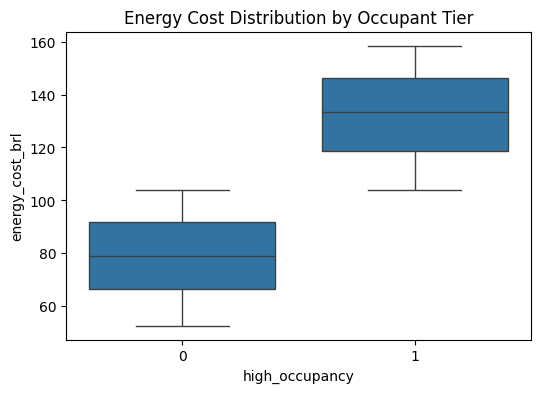

In [126]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='high_occupancy', y='energy_cost_brl', data=df)
plt.title('Energy Cost Distribution by Occupant Tier')
plt.show()

This new feature has a very strong, non-linear correlation with energy_cost_brl.

<Axes: >

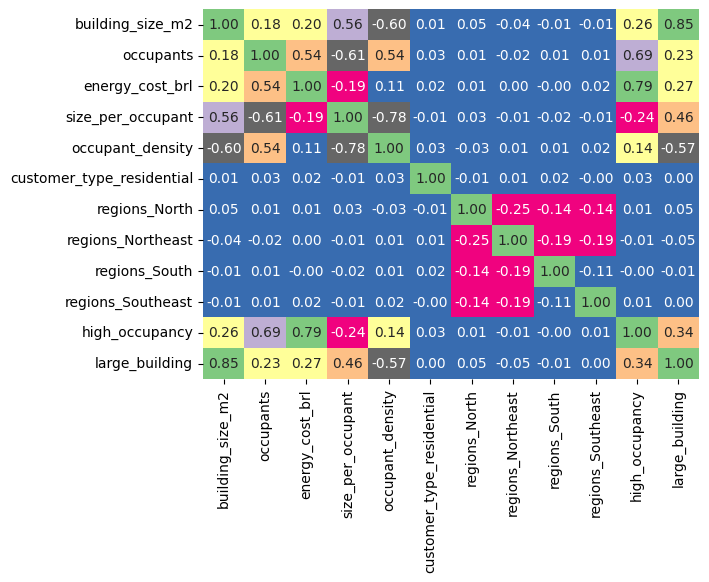

In [128]:
# Check correlation of continuous/ordinal features
corr = df.corr(numeric_only=True)
sns.heatmap(corr,
            annot=True, fmt='.2f',cmap="Accent_r",
            cbar=False)

### Permutation Importance (Model Agnostic)
This is highly recommended, especially when features are engineered based on rules. Permutation Importance measures how much the model's performance drops when a feature is randomly shuffled (breaking its relationship with the target).

In [133]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

# Prepare the data
X = df.drop(['energy_cost_brl', 'customer_id'], axis=1)
y = df['energy_cost_brl']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Train the model
model = RandomForestRegressor(random_state=42).fit(X_train, y_train)

# Calculate Permutation Importance on the test set
result = permutation_importance(
    model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

# Display the importance scores
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': result.importances_mean
}).sort_values(by='importance', ascending=False)

print(importance_df)

/Users/nico/.pyenv/versions/3.11/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Users/nico/.pyenv/versions/3.11/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Users/nico/.pyenv/versions/3.11/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using thi

                      feature  importance
9              high_occupancy    0.358651
1                   occupants    0.246588
4   customer_type_residential    0.005145
6           regions_Northeast    0.000291
10             large_building   -0.000837
7               regions_South   -0.000984
8           regions_Southeast   -0.002100
5               regions_North   -0.003135
0            building_size_m2   -0.007871
2           size_per_occupant   -0.009915
3            occupant_density   -0.010399


Mutual Information measures the dependency between two random variables. Unlike the Pearson correlation coefficient (which only detects linear relationships), MI can detect any statistical relationship, including non-linear and step-wise ones.

MI quantifies the reduction in uncertainty about one variable (e.g., our target energy_cost_brl) given that you know the value of the other variable.

In [137]:
# Assuming X contains your features (including engineered ones) and y is the target
X = df[['high_occupancy', 'occupant_density', 'building_size_m2', 'occupants', 'large_building', 'building_size_m2', 'size_per_occupant']]
y = df['energy_cost_brl']

# Calculate MI scores
mi_scores = mutual_info_regression(X, y, random_state=42)

# Combine into a DataFrame for easy inspection
mi_results = pd.DataFrame({
    'feature': X.columns,
    'mi_score': mi_scores
}).sort_values(by='mi_score', ascending=False)

print(mi_results)

             feature  mi_score
3          occupants  0.436981
0     high_occupancy  0.422818
1   occupant_density  0.391707
6  size_per_occupant  0.390099
4     large_building  0.076561
5   building_size_m2  0.072801
2   building_size_m2  0.072671


### Feature Selection

Recommendation: Use high_occupancy and DROP occupants and occupant_density.

Why: energy_cost_brl, was generated using a binary rule (if $1 \le \text{occupants} \le 3$, then low cost; else high cost).
- The high_occupancy feature perfectly captures this rule. It is the cleanest and most direct signal.
- The raw occupants feature is noisier. A linear model would fail to see the "jump" at 3. A tree model (like a Random Forest) would just spend its first split re-creating the high_occupancy feature (e.g., "is occupants $\le 3$?"). Better off just giving it the feature directly.
- The occupant_density is even noisier (lower MI score), as it mixes the building_size signal with the occupant signal.

2. The Building Size Group (The Secondary Signal)

- large_building: 0.076
- building_size_m2: 0.072

Recommendation: Use large_building and DROP building_size_m2.
Why:The exact same logic applies. The occupants variable itself was generated based on a binary split of building_size_m2 ($\le 44$ vs. $> 44$).

### Modeling

In [149]:
df.columns

Index(['customer_id', 'building_size_m2', 'occupants', 'energy_cost_brl',
       'size_per_occupant', 'occupant_density', 'customer_type_residential',
       'regions_North', 'regions_Northeast', 'regions_South',
       'regions_Southeast', 'high_occupancy', 'large_building'],
      dtype='object')

In [158]:
X = df[['high_occupancy', 'large_building', 'size_per_occupant', 'regions_North', 'regions_Northeast', 'regions_South', 'regions_Southeast', 'customer_type_residential']]
y = df['energy_cost_brl']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
models = {
'Linear Regression': LinearRegression(),
'Decision Tree': DecisionTreeRegressor(random_state=42),
'Random Forest': RandomForestRegressor(random_state=42)
}

In [161]:
# We want to measure Root Mean Squared Error (RMSE)
# scikit-learn's 'scoring' wants a utility, not a loss (higher is better)
# So we use 'neg_root_mean_squared_error' and flip the sign back.
scoring_metric = 'neg_root_mean_squared_error'

cv_results = []

for name, model in models.items():

    scores = cross_val_score(model, X_train, y_train, cv=5, scoring=scoring_metric)

    # Flip the sign back to get positive RMSE scores
    rmse_scores = -scores

    cv_results.append((name, rmse_scores.mean(), rmse_scores.std()))

cv_df = pd.DataFrame(cv_results, columns=['Model', 'Mean RMSE', 'Std Dev']).sort_values(by='Mean RMSE')
print(cv_df)

               Model  Mean RMSE   Std Dev
0  Linear Regression  15.096631  0.345756
2      Random Forest  15.596496  0.415110
1      Decision Tree  15.634442  0.415651


In [162]:
final_model = LinearRegression()

# Train the model on the ENTIRE training dataset
final_model.fit(X_train, y_train)

y_preds = final_model.predict(X_test)

final_rmse = np.sqrt(mean_squared_error(y_test, y_preds))
final_r2 = r2_score(y_test, y_preds)

print("--- Final Model Performance on Test Set ---")
print(f"Model: Linear Regression")
print(f"Test RMSE: {final_rmse:.2f}")
print(f"Test R-squared: {final_r2:.2f}")

--- Final Model Performance on Test Set ---
Model: Linear Regression
Test RMSE: 15.00
Test R-squared: 0.61


In [168]:
low_occupancy_mean = y_train[X_train['high_occupancy'] == 0].mean()
high_occupancy_mean = y_train[X_train['high_occupancy'] == 1].mean()

print(f"Low Occupancy Mean Energy Cost: {low_occupancy_mean:.2f}")
print(f"High Occupancy Mean Energy Cost: {high_occupancy_mean:.2f}")

Low Occupancy Mean Energy Cost: 78.76
High Occupancy Mean Energy Cost: 132.56


In [169]:
# simple heuristics baseline
baseline_preds = np.where(X_test['high_occupancy'] == 1, 132.56, 78.76)
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_preds))
baseline_r2 = r2_score(y_test, baseline_preds)
print("--- Baseline Performance on Test Set ---")
print(f"Baseline RMSE: {baseline_rmse:.2f}")
print(f"Baseline R-squared: {baseline_r2:.2f}")

--- Baseline Performance on Test Set ---
Baseline RMSE: 14.96
Baseline R-squared: 0.62


In [170]:
X_decision_tree = df[['high_occupancy']]
y = df['energy_cost_brl']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

decision_tree_model = DecisionTreeRegressor(random_state=42)
decision_tree_model.fit(X_train, y_train)
y_preds_dt = decision_tree_model.predict(X_test)
dt_rmse = np.sqrt(mean_squared_error(y_test, y_preds_dt))
dt_r2 = r2_score(y_test, y_preds_dt)
print("--- Decision Tree Model Performance on Test Set ---")
print(f"Decision Tree RMSE: {dt_rmse:.2f}")
print(f"Decision Tree R-squared: {dt_r2:.2f}")

--- Decision Tree Model Performance on Test Set ---
Decision Tree RMSE: 15.32
Decision Tree R-squared: 0.60


IndexError: list index out of range

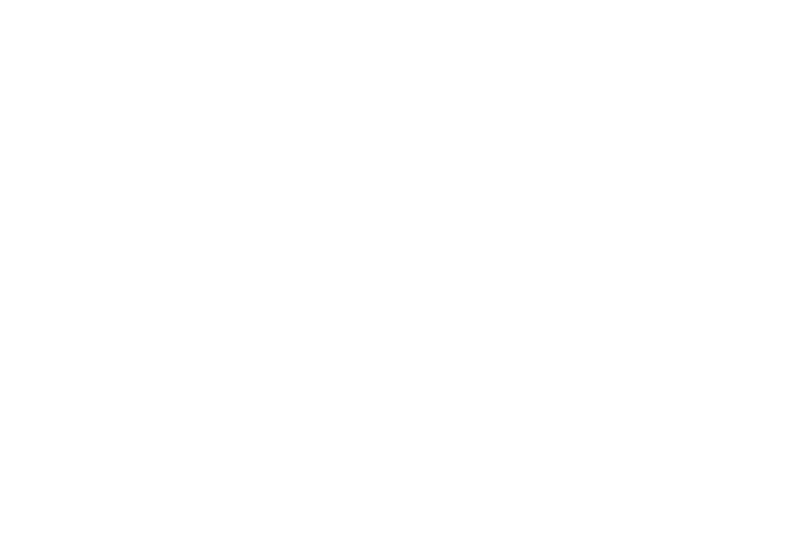

In [171]:
from sklearn.tree import plot_tree

# Create a figure to plot in
plt.figure(figsize=(10, 7))

# Plot the tree
plot_tree(
    decision_tree_model,
    feature_names=X_decision_tree.columns.to_list(),
    filled=True,  # Color the nodes
    rounded=True, # Use rounded boxes
    fontsize=12
)

plt.title("Decision Tree Learned from Training Data")
plt.show()